In [1]:

import os
#if you are using google colab. first mount google drive to your ipynb. Othewise comment out this line of code.
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
#used for showing progress
import tqdm

#### Use This only if you have all files under one folder (no train test seperate folder.

In [3]:
# path of data directory
training_dir = "/content/drive/MyDrive/Colab Notebooks/Image Processing/keukomia/Original"
img_dir_list = os.listdir(training_dir)

# list file address and class
DATA_DF = []
for img_dir in img_dir_list:
  file_dir = os.listdir(training_dir+"/"+img_dir)
  for file_name in file_dir:
    DATA_DF.append([training_dir+"/"+img_dir+"/"+file_name,img_dir])

In [4]:
# convert to pandas data frame
import pandas as pd

Train_Data_Frame = pd.DataFrame(DATA_DF, columns = ["file_name","class"])
Train_Data_Frame.head()

,file_name,class
0,/content/drive/MyDrive/Colab Notebooks/Image P...,Pre
1,/content/drive/MyDrive/Colab Notebooks/Image P...,Pre
2,/content/drive/MyDrive/Colab Notebooks/Image P...,Pre
3,/content/drive/MyDrive/Colab Notebooks/Image P...,Pre
4,/content/drive/MyDrive/Colab Notebooks/Image P...,Pre


[]

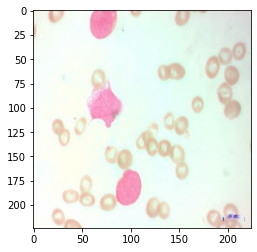

In [5]:
# showing demo of dataset
import cv2
import matplotlib.pyplot as plt

get_file_name = Train_Data_Frame.iloc[0]

img = cv2.imread(get_file_name['file_name'])

plt.imshow(img)
plt.plot()


In [6]:
# using random shuffle for randomize our dataset. 
from sklearn.utils import shuffle
Train_Data_Frame = Train_Data_Frame = shuffle(Train_Data_Frame)

Train_Data_Frame.head()

,file_name,class
3049,/content/drive/MyDrive/Colab Notebooks/Image P...,Benign
1660,/content/drive/MyDrive/Colab Notebooks/Image P...,Pro
2519,/content/drive/MyDrive/Colab Notebooks/Image P...,Early
362,/content/drive/MyDrive/Colab Notebooks/Image P...,Pre
2601,/content/drive/MyDrive/Colab Notebooks/Image P...,Early


#### spliting data into trainig and testing

In [7]:

from sklearn.model_selection import train_test_split
Train_Data,Test_Data = train_test_split(Train_Data_Frame,train_size=0.9,shuffle=True,random_state=42)

#### As we have limited number of image sample, we will use image augmentation technique

In [8]:

from keras.preprocessing.image import ImageDataGenerator

In [9]:
Generator = ImageDataGenerator(rescale=1./255,
                               zoom_range=0.2,
                              shear_range=0.2,
                              rotation_range=40,
                              horizontal_flip=True,
                               fill_mode="nearest",
                              validation_split=0.1)

In [10]:
Test_Generator = ImageDataGenerator(rescale=1./255)

In [11]:
# image size
image_size_tag = (192, 192)

In [12]:
Train_IMG_Set = Generator.flow_from_dataframe(dataframe=Train_Data,
                                             x_col="file_name",
                                             y_col="class",
                                            image_size=image_size_tag,
                                             class_mode="categorical",
                                             subset="training")

Found 2637 validated image filenames belonging to 4 classes.


In [13]:
Validation_IMG_Set = Generator.flow_from_dataframe(dataframe=Train_Data,
                                                  x_col="file_name",
                                                  y_col="class",
                                                  image_size=image_size_tag,
                                                  class_mode="categorical",
                                                  subset="validation")

Found 293 validated image filenames belonging to 4 classes.


In [14]:
Test_IMG_Set = Generator.flow_from_dataframe(dataframe=Test_Data,
                                                 x_col="file_name",
                                                 y_col="class",
                                                 image_size=image_size_tag,
                                                 class_mode="categorical")

Found 326 validated image filenames belonging to 4 classes.


In [15]:
train_data, test_data = Train_IMG_Set, Validation_IMG_Set

#### Use This code if you have seperate folder for training and testing

In [16]:
'''# example of progressively loading images from file
from keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.2,
                                    horizontal_flip = True,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2)

#train_generator = ImageDataGenerator(rescale = 1./255)

test_generator = ImageDataGenerator(rescale = 1./255)

# prepare an iterators for each dataset
train_data = train_generator.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/ML/images_train_test_val/train', class_mode='categorical',target_size = (224,224), batch_size=64)
test_data = test_generator.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/ML/images_train_test_val/test', class_mode='categorical',target_size = (224,224), batch_size=64)
# confirm the iterator works
batchX, batchy = train_data.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))'''

"# example of progressively loading images from file\nfrom keras.preprocessing.image import ImageDataGenerator\ntrain_generator = ImageDataGenerator(rescale = 1./255,\n                                    shear_range = 0.2,\n                                    zoom_range = 0.2,\n                                    horizontal_flip = True,\n                                    width_shift_range=0.2,\n                                    height_shift_range=0.2)\n\n#train_generator = ImageDataGenerator(rescale = 1./255)\n\ntest_generator = ImageDataGenerator(rescale = 1./255)\n\n# prepare an iterators for each dataset\ntrain_data = train_generator.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/ML/images_train_test_val/train', class_mode='categorical',target_size = (224,224), batch_size=64)\ntest_data = test_generator.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/ML/images_train_test_val/test', class_mode='categorical',target_size = (224,224), batch_size=64)\n# confi

#### Model Building

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, GlobalAveragePooling2D,Dropout
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
import tensorflow as tf

In [18]:
def make_model(model_type):
  model = model = Sequential()
  model.add(model_type)
  for layer in model.layers:
    # make this true if you want to train VGG16 model also
    layer.trainable = False

  model.add(GlobalAveragePooling2D())
  model.add(Dense(2048, activation="relu"))
  model.add(Dropout(0.15))
  model.add(Dense(2048, activation="relu"))
  model.add(Dropout(0.15))
  model.add(Dense(1024, activation="relu"))
  #adding final dense layer
  model.add(Dense(4,activation="softmax"))

  return model

In [19]:
model_type = tf.keras.applications.VGG19(weights='imagenet',input_shape=(224, 224, 3), include_top=False)

model = make_model(model_type)

print(model.summary())

80150528/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2048)              1050624   
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 2048)              4196352   
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0 

#### creating custom function for measuring f1 score

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#### compile model

In [ ]:
model.compile(loss = "categorical_crossentropy",
              optimizer = "rmsprop",
              metrics = ["accuracy",tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),f1_m,tf.keras.metrics.AUC()]
              )

#### we are reducing learning rate to prevent overfitting

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=3, min_denta=0.0001, mode='auto', verbose=1)

# using tensorboard 
tensorboard = TensorBoard(log_dir='logs')

# give location of file where you want to save model while trainng the model with 'cnn_classification.h5' name
file_path = "/content/drive/MyDrive/Colab Notebooks/ML/images_train_test_val/cnn_classification.h5"
# saves the best fitted model
checkpoint = ModelCheckpoint(file_path, monitor='val_accuracy', save_best_only=True, mode='auto', verbose=1)

In [ ]:
# we are using batch size of 5000
img_batch_size = 5000

hist = model.fit(train_data,
                           epochs = 50,
                           validation_data=test_data,
                           batch_size=img_batch_size,callbacks=[tensorboard, checkpoint, reduce_lr]
                           )

Epoch 1/50
83/83 [==============================] - ETA: 0s - loss: 1.2824 - accuracy: 0.5768 - precision: 0.6801 - recall: 0.4338 - f1_m: 0.5027 - auc: 0.8137
Epoch 00001: val_accuracy improved from -inf to 0.79181, saving model to /content/drive/MyDrive/Colab Notebooks/ML/images_train_test_val/custom_cnn_classification.h5
83/83 [==============================] - 374s 4s/step - loss: 1.2824 - accuracy: 0.5768 - precision: 0.6801 - recall: 0.4338 - f1_m: 0.5027 - auc: 0.8137 - val_loss: 0.5096 - val_accuracy: 0.7918 - val_precision: 0.8233 - val_recall: 0.7474 - val_f1_m: 0.7842 - val_auc: 0.9575 - lr: 0.0010
Epoch 2/50
83/83 [==============================] - ETA: 0s - loss: 0.5564 - accuracy: 0.7918 - precision: 0.8277 - recall: 0.7486 - f1_m: 0.7842 - auc: 0.9469
Epoch 00002: val_accuracy did not improve from 0.79181
83/83 [==============================] - 64s 766ms/step - loss: 0.5564 - accuracy: 0.7918 - precision: 0.8277 - recall: 0.7486 - f1_m: 0.7842 - auc: 0.9469 - val_loss: 

In [ ]:
results = model.evaluate(Test_IMG_Set)

11/11 [==============================] - 44s 4s/step - loss: 0.0283 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - f1_m: 0.9915 - auc: 0.9999


In [ ]:
results

[0.028294051066040993,
 0.9907975196838379,
 0.9907975196838379,
 0.9907975196838379,
 0.9914772510528564,
 0.9998776912689209]

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'f1_m', 'auc', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_f1_m', 'val_auc', 'lr'])


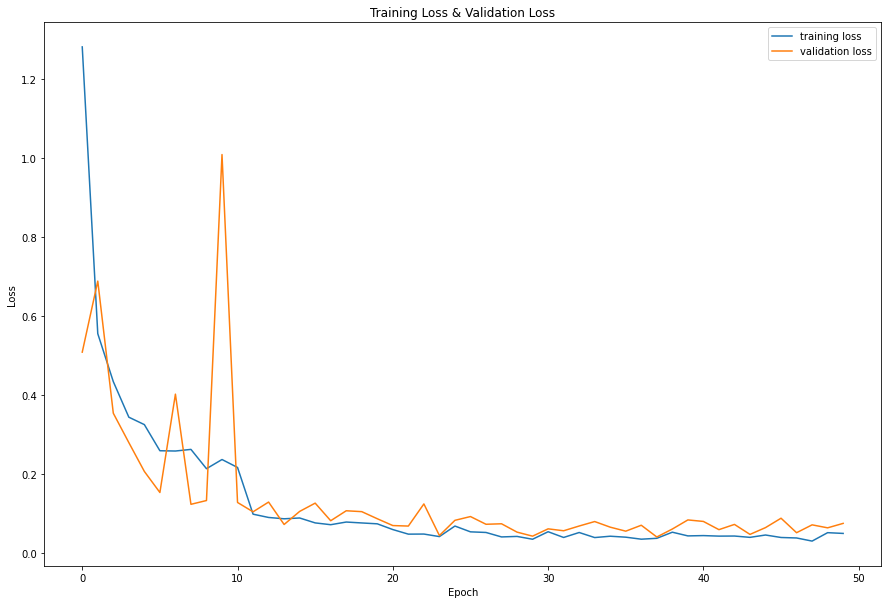

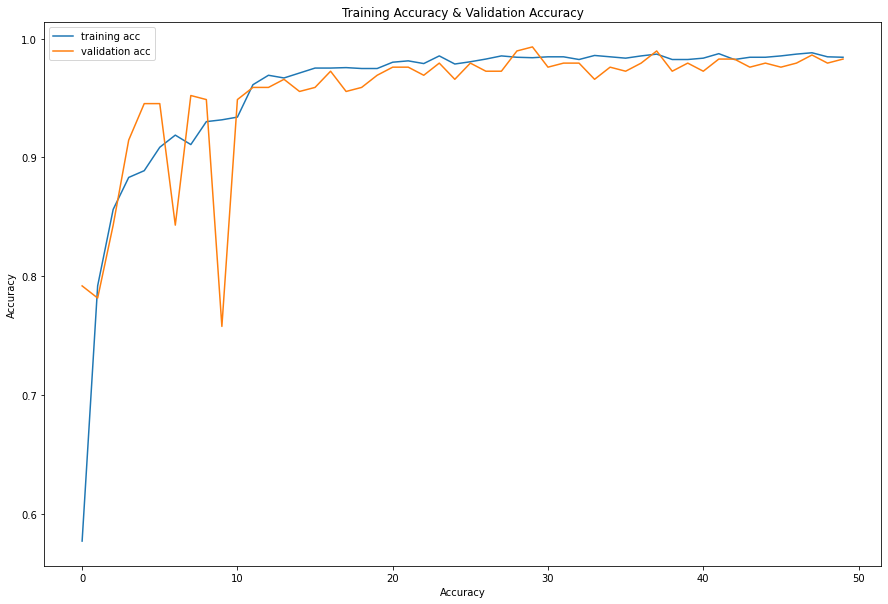

In [ ]:
import matplotlib.pyplot as plt
print(hist.history.keys())
plt.figure(figsize=(15,10))
plt.plot(hist.history["loss"],label = "training loss")
plt.plot(hist.history["val_loss"],label = "validation loss")
plt.title("Training Loss & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(15,10))
plt.plot(hist.history["accuracy"],label = "training acc")
plt.plot(hist.history["val_accuracy"],label = "validation acc")
plt.title("Training Accuracy & Validation Accuracy")
plt.xlabel("Accuracy")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
model.save_weights("VGG16.h5")